In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import json
from collections import Counter
from networkx.algorithms.community import greedy_modularity_communities
from itertools import combinations
from scipy.spatial.distance import jaccard
import matplotlib.cm as cm
from scipy.stats import spearmanr


In [ ]:
# Load dataset paths
edge_list_path = 'data/lastfm_asia_edges.csv'
target_path = 'data/lastfm_asia_target.csv'
features_path = 'data/lastfm_asia_features.json'

In [7]:
#Preprocess
targets_df = pd.read_csv(target_path)

with open(features_path) as f:
    features = json.load(f)

# Load the edgelist from the CSV file
G = nx.read_edgelist(edge_list_path, delimiter=",")

# Load the features for each node
for node, feature in features.items():
    G.nodes[node]['features'] = feature


# Basic Info about the Network
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("First few rows of targets:\n", targets_df.head())

# Calculate density
density = nx.density(G)
print("Density:", density)

# Calculate transitivity (global clustering coefficient)
transitivity = nx.transitivity(G)
print("Transitivity:", transitivity)


node_id = '1'
print(f"Node {node_id} has features: {G.nodes[node_id]['features']}")



Number of nodes: 7626
Number of edges: 27807
First few rows of targets:
    id  target
0   0       8
1   1      17
2   2       3
3   3      17
4   4       5
Density: 0.0009564174330267893
Transitivity: 0.178622548153384
Node 1 has features: [7375, 1890, 2400, 1122, 980, 1441, 6283, 2907, 7387, 983, 7388, 7389, 6913, 5885, 1449, 526, 1451, 3915, 5537, 4906, 5395, 3406, 3919, 7401, 3923, 3924, 7406, 2921, 3928, 2446, 7410, 7411, 6413, 4427, 50, 542, 7419, 2442, 1934, 55, 1471, 7206, 6948, 2939, 4932, 3726, 556, 3945, 5423, 7, 1895, 5622, 6038, 6725, 6438, 6924, 570, 3389, 3211, 5434, 574, 4455, 7442, 4457, 6908, 5438, 1045, 1663, 7452, 2974, 1519, 5445, 583, 2964, 1987, 5450, 96, 2477, 3486, 2478, 3487, 4476, 1517, 6993, 4948, 2483, 7464, 108, 7466, 6468, 2983, 2913, 4981, 7183, 2420, 5342, 2991, 6472, 2011, 1747, 4492, 5970, 7014, 2502, 123, 2436, 3509, 4504, 4505, 3513, 7489, 4655, 5890, 5002, 1537, 7494, 3523, 5476, 4901, 2652, 7028, 931, 709, 1090, 4516, 2029, 130, 4349, 1551, 2529, 

In [9]:
# Community detection using Greedy Modularity method
communities = list(greedy_modularity_communities(G))
community_map = {node: i for i, community in enumerate(communities) for node in community}
# Add community information to each node
for node, community in community_map.items():
    G.nodes[node]['community'] = community
# Number of detected communities and sizes
num_communities = len(communities)
community_sizes = [len(community) for community in communities]
print(f"Number of communities detected: {num_communities}")
print("Top 5 largest communities:", sorted(community_sizes, reverse=True)[:5])



Number of communities detected: 45
Top 5 largest communities: [1519, 1427, 1043, 985, 721]


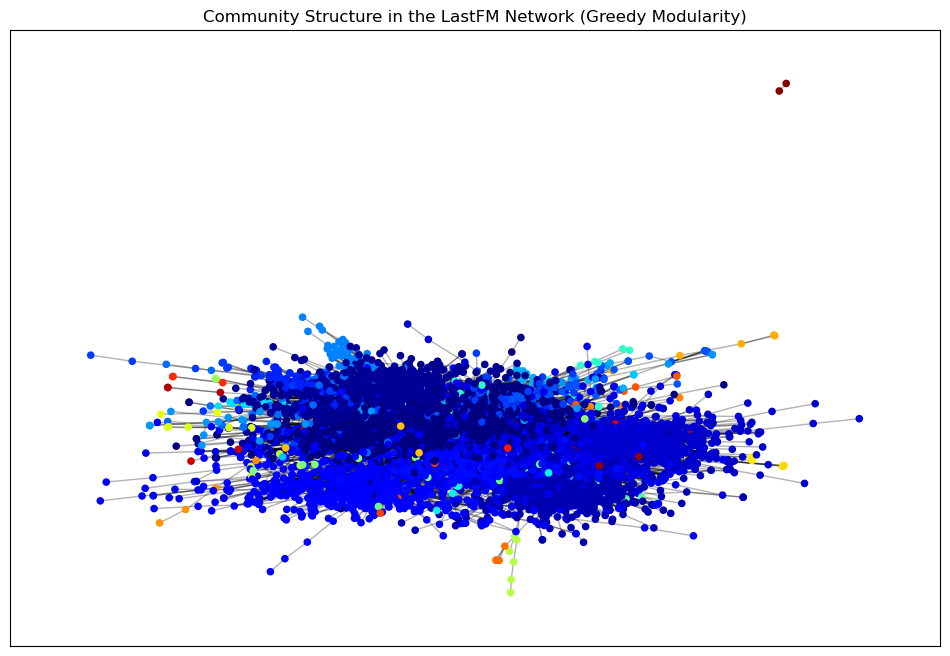

In [56]:
# Network visualization with community structure
pos = nx.spring_layout(G, seed=42)  # Consistent layout for visualization
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=20, cmap=plt.cm.jet,
                       node_color=[community_map[node] for node in G.nodes()])
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Community Structure in the LastFM Network (Greedy Modularity)")
plt.show()


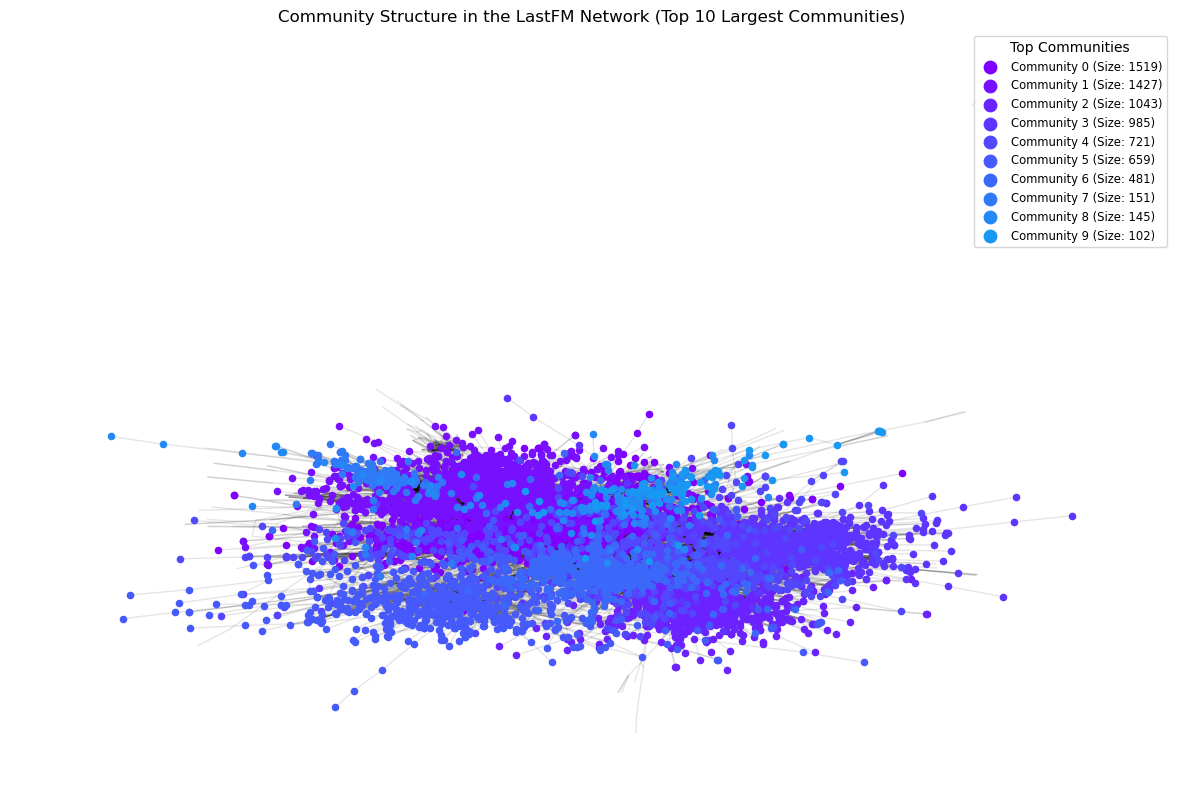

In [11]:
pos = nx.spring_layout(G, seed=42, iterations=50)  # Adjust iterations for performance

# Define a color map for the communities
colors = cm.rainbow(np.linspace(0, 1, len(communities)))

# Plot the communities
plt.figure(figsize=(15, 10))

# Draw only the largest communities (e.g., top 10)
top_communities = sorted(communities, key=len, reverse=True)[:10]  # Adjust the number as needed

for i, community in enumerate(top_communities):
    community_nodes = list(community)
    nx.draw_networkx_nodes(G, pos, nodelist=community_nodes,
                           node_size=20, node_color=[colors[i]],
                           label=f'Community {i} (Size: {len(community)})')

# Draw edges with transparency for less clutter
nx.draw_networkx_edges(G, pos, alpha=0.1)

# Add title and legend
plt.title("Community Structure in the LastFM Network (Top 10 Largest Communities)")
plt.legend(loc='best', fontsize='small', markerscale=2, title="Top Communities")
plt.axis('off')
plt.show()

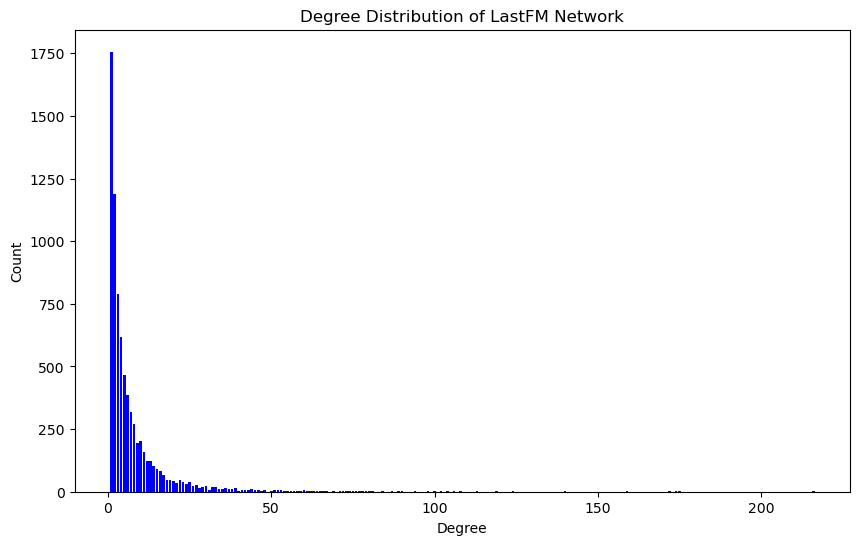

In [84]:
# Degree distribution analysis
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

# Plotting Degree Distribution
plt.figure(figsize=(10, 6))
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Degree Distribution of LastFM Network")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [62]:
Centrality within Communities
centrality = nx.betweenness_centrality(G)
centrality_scores = {comm: [] for comm in range(num_communities)}
for node, score in centrality.items():
    if 'community' in G.nodes[node]:
        community_id = G.nodes[node]['community']
        centrality_scores[community_id].append(score)
avg_centrality_per_community = {comm: np.mean(scores) for comm, scores in centrality_scores.items()}
print("Average centrality per community:", avg_centrality_per_community)

Average centrality per community: {0: 0.0006072329323414273, 1: 0.0006173607413322903, 2: 0.000562335748805537, 3: 0.0005204783820106573, 4: 0.0004988416999306941, 5: 0.0006404491880255188, 6: 0.0005060615813678661, 7: 0.00047627899271152454, 8: 0.00039886257651638936, 9: 0.0005864322186897147, 10: 0.00021690178151732452, 11: 0.00042633488681215897, 12: 0.00036451458102001994, 13: 0.0003351208461816605, 14: 0.0002395716319643208, 15: 0.0001854580584644902, 16: 0.0002689631073920909, 17: 0.00025040476390853655, 18: 0.00029581042465224656, 19: 0.000226046456493553, 20: 0.0002552326932028653, 21: 0.0002724423053193759, 22: 0.00025667716354484436, 23: 0.00019341941259164614, 24: 0.00019818634713144866, 25: 0.0003058847814494349, 26: 0.0002813773741426599, 27: 0.00035449605776769177, 28: 0.00022651667919849653, 29: 0.0003182557534039514, 30: 0.00020972597319938763, 31: 0.00022738125585503472, 32: 0.0004718765589252232, 33: 0.00039327060361584647, 34: 0.00027514344336730277, 35: 0.0001966439